# Business Case 4: Cryptocurrencies Forecasting

## Contents:
  
 * [Modeling LUNA1](#Modeling)
 * [LUNA1 - Entire Dataset](#entiredataset)
    * [Model 1: LSTM](#lstm)
    * [Model 2: XGBOOST Regressor](#xgboost)
 * [LUNA1 - since January 2021](#jan2021)
    * [Model 1: LSTM](#lstm2)
    * [Model 2: XGBOOST Regressor](#xgboost2)
 * [LUNA1 - since January 2022](#jan2022)
    * [Model 1: LSTM](#lstm3)
    * [Model 2: XGBOOST Regressor](#xgboost3)
 * [Predictions for the next two days using the best model](#predictions)
 * [Final Predictions](#finalpredictions)

## Imports

In [1]:
#! pip install xgboost
#! pip install fastai==0.7.0
#! pip install --upgrade tensorflow
#! pip install keras
#! pip install pystan
#! pip install ephem
#! pip install fbprophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import ceil
import math
import scipy.stats as stats
from itertools import cycle

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

import json
import requests
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error , mean_absolute_error, explained_variance_score, r2_score
from tensorflow.keras import layers
from xgboost import XGBRegressor

import warnings

# Modeling - LUNA1 <a name="Modeling"></a>
>In this step, we decided to implement algorithms (LSTM, XGBOOST Regressor) that can predict the closing price of LUNA1.

# LUNA1 - Entire Dataset <a name="entiredataset"></a>

In [3]:
luna = pd.read_csv('LUNA1.csv', index_col = 'Date')

In [4]:
luna.head()

,close,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,
2019-08-10,0.008684,0.299352,0.099172,0.994653,0.314675,0.101975
2019-08-11,0.009879,0.468337,0.178013,0.998764,0.314675,0.104684
2019-08-12,0.009961,0.540877,0.190604,0.993229,0.327335,0.102432
2019-08-13,0.010847,0.765111,0.232462,0.997856,0.333160,0.094655
2019-08-14,0.010140,0.765113,0.114106,0.992677,0.308660,0.081170


# Model 1: LSTM <a name="lstm"></a>

In [5]:
data = luna.copy()

In [6]:
data.head()

,close,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,
2019-08-10,0.008684,0.299352,0.099172,0.994653,0.314675,0.101975
2019-08-11,0.009879,0.468337,0.178013,0.998764,0.314675,0.104684
2019-08-12,0.009961,0.540877,0.190604,0.993229,0.327335,0.102432
2019-08-13,0.010847,0.765111,0.232462,0.997856,0.333160,0.094655
2019-08-14,0.010140,0.765113,0.114106,0.992677,0.308660,0.081170


In [7]:
#Splitting the original dataset using all the variables (hist) and "close" (target) using 7 days a the length of the sliding window

hist = []
target = []
length = 7

for i in range(len(data)-length):
    t = data['close']
    v = data[['close', 'BTC_closeprice', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [8]:
print(len(hist[0]))  #nr of days
print(len(hist)) #size of train dataset
print(len(target)) #size of test dataset

7
983
983


In [9]:
#convert lists to arrays
hist = np.array(hist)
target = np.array(target)

In [10]:
target = target.reshape(-1,1)
target.shape

(983, 1)

In [11]:
#Splitting the datasets into train and test using 80% for train and 20% for test

training_size=int(len(data)*0.80)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [12]:
#Nr of instances, # nr of days (length), #nr of columns
X_train.shape

(792, 7, 5)

In [13]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,5), dropout = 0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=40, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 20)             2080      
                                                                 
 lstm_1 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_2 (LSTM)               (None, 40)                11680     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 20,585
Trainable params: 20,585
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, shuffle = False, validation_split=0.2)

Epoch 1/30
20/20 [==============================] - 4s 38ms/step - loss: 0.0019 - val_loss: 0.0347
Epoch 2/30
20/20 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0308
Epoch 3/30
20/20 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0263
Epoch 4/30
20/20 [==============================] - 0s 9ms/step - loss: 9.8670e-04 - val_loss: 0.0223
Epoch 5/30
20/20 [==============================] - 0s 9ms/step - loss: 6.4936e-04 - val_loss: 0.0175
Epoch 6/30
20/20 [==============================] - 0s 9ms/step - loss: 5.4341e-04 - val_loss: 0.0160
Epoch 7/30
20/20 [==============================] - 0s 10ms/step - loss: 4.1657e-04 - val_loss: 0.0154
Epoch 8/30
20/20 [==============================] - 0s 10ms/step - loss: 5.1888e-04 - val_loss: 0.0147
Epoch 9/30
20/20 [==============================] - 0s 10ms/step - loss: 4.3296e-04 - val_loss: 0.0156
Epoch 10/30
20/20 [==============================] - 0s 10ms/step - loss: 7.5663e-04 - val

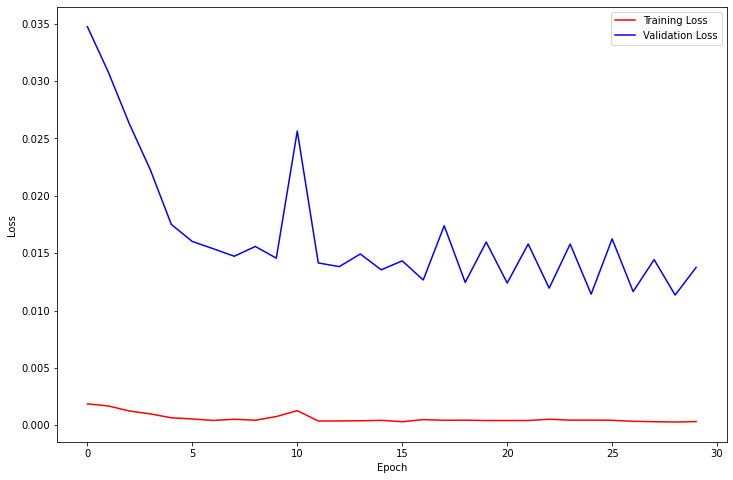

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [17]:
pred_test = model.predict(X_test)
pred_train = model.predict (X_train)

In [18]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
186,0.779765,0.155044,2022-04-21
187,0.804559,0.157938,2022-04-22
188,0.768891,0.160537,2022-04-23
189,0.777710,0.162401,2022-04-24
190,0.833397,0.166362,2022-04-25


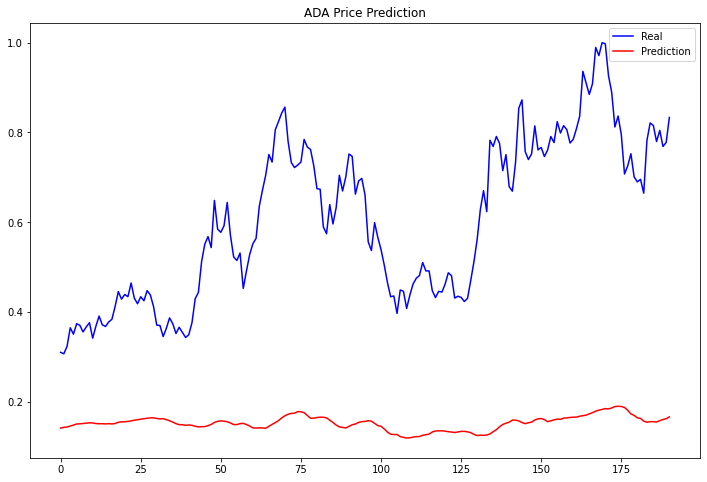

In [19]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('ADA Price Prediction')
plt.legend()
plt.show()

In [20]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.05344605307806447
Train data MSE:  0.002856480589623285
Train data MAE:  0.020746412436695207
-------------------------------------------------------------------------------------
Test data RMSE:  0.4823440352103765
Test data MSE:  0.23265576830302895
Test data MAE:  0.4511220268467735


In [21]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.6159677270518349
Test data R2 score: -6.300579648618007


# Model 2: XGBoost Regressor  <a name="xgboost"></a>

In [22]:
data1 = luna.copy()
data1.reset_index(inplace = True)
data1.shape

(990, 7)

In [23]:
close_stock = data1.copy()
print("Total data for prediction: ",data1.shape[0])

Total data for prediction:  990


In [24]:
data1.set_index('Date', inplace = True)
data1.shape

(990, 6)

In [25]:
#Train and test split using 80% for train and 20% for test
training_size=int(len(data1)*0.80)
test_size=len(data1)-training_size
train_data,test_data=data1.iloc[:training_size,:],data1.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (792, 6)
test_data:  (198, 6)


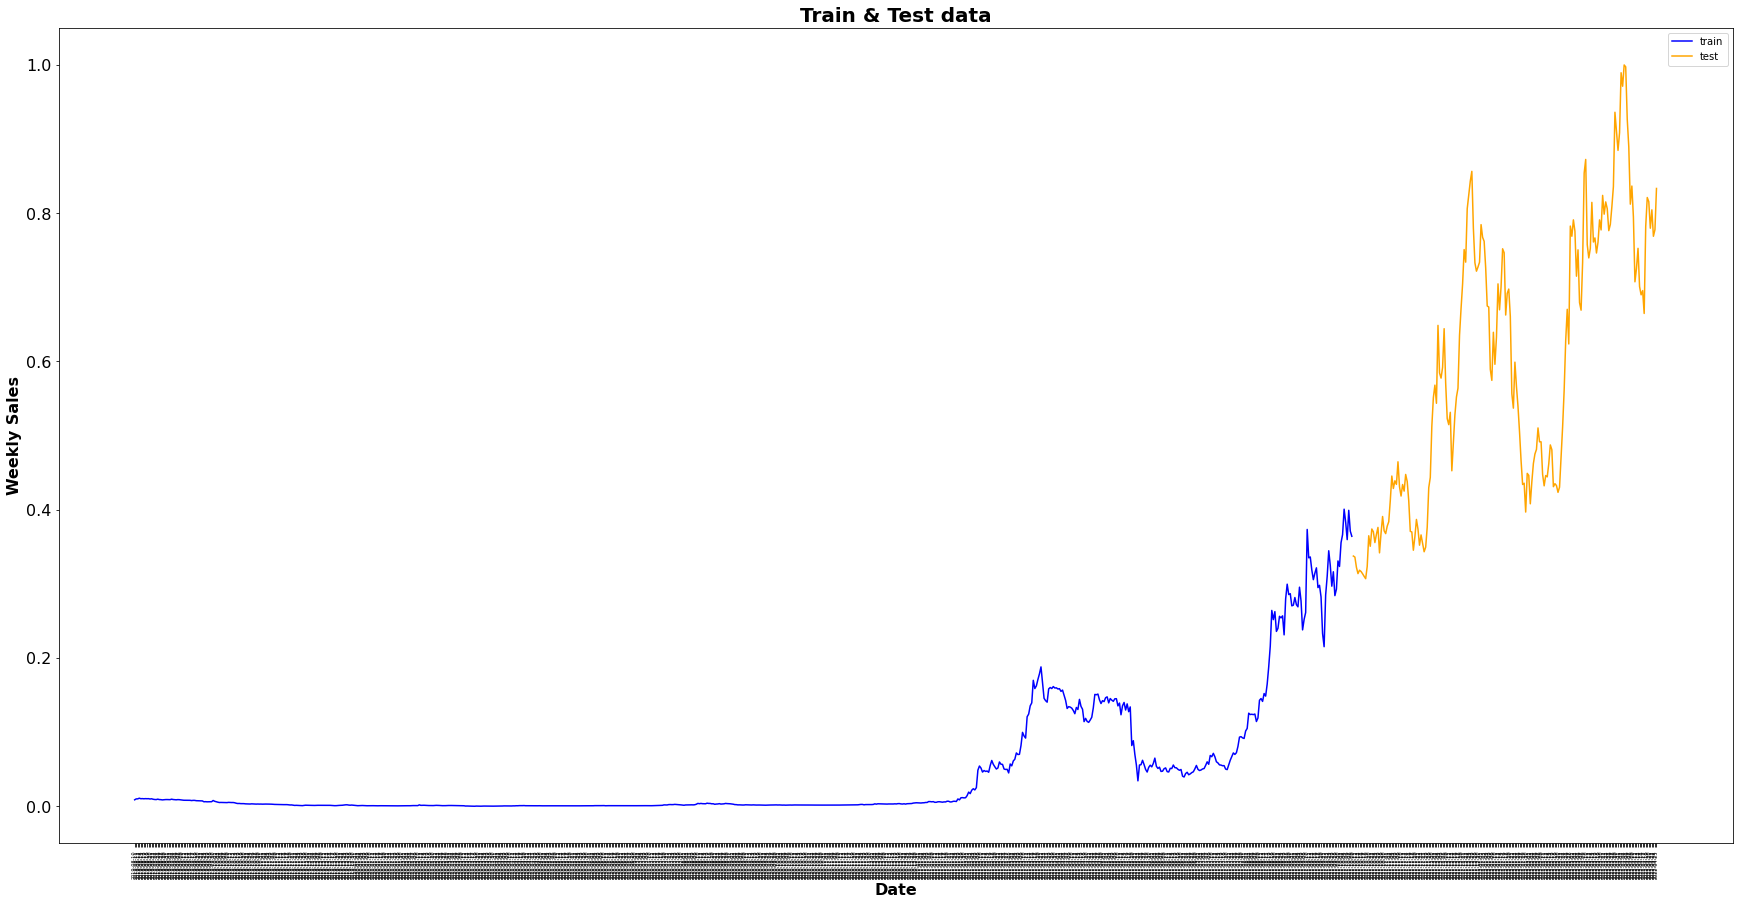

In [26]:
data1.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(30, 15))
sns.lineplot(x = close_stock['Date'][:training_size], y = close_stock['close'][:training_size], color = 'blue')
sns.lineplot(x = close_stock['Date'][training_size:], y = close_stock['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', labelsize=5)
plt.xticks(rotation='vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [27]:
data1.set_index('Date', inplace = True)

In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), 0:]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [29]:
#Sliding window = 7 or 20
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (784, 7, 6)
y_train:  (784,)
X_test:  (190, 7, 6)
y_test (190,)


In [30]:
#Reshaping the arrays because XGBRegressor only accepts 1-Dimensional arrays
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [31]:
model2 = XGBRegressor(n_estimators=100, random_state = 1, eta = 0.2)
model2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0, ...)

In [32]:
predictions = model2.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model2.predict(X_train)

In [33]:
results2 = np.concatenate((y_test, predictions),axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data1['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
185,0.815509,0.373659,2022-04-21
186,0.779765,0.370039,2022-04-22
187,0.804559,0.382046,2022-04-23
188,0.768891,0.385699,2022-04-24
189,0.777710,0.376277,2022-04-25


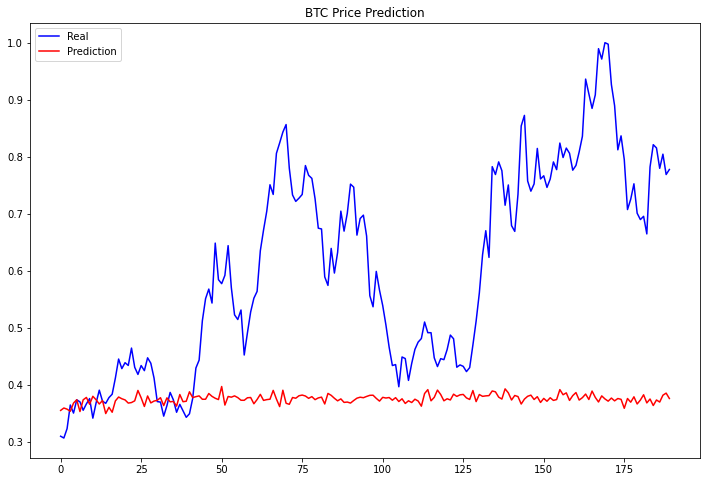

In [34]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(predictions, color='red', label='Prediction')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()

In [35]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  2.4326200709497727e-07
Mean Absolute Error - MAE : 0.00030161726850242153
Root Mean squared Error - RMSE : 0.000493215984224941
R^2 Score 0.9999637034446174
--------------------------------------------------------------
Test data MSE:  0.08268270553681106
Mean Absolute Error - MAE : 0.23100126251326314
Root Mean squared Error - RMSE : 0.28754600594828483
R^2 Score -1.6035989927850607


# LUNA - since January 2021  <a name="jan2021"></a>

# Model 1: LSTM <a name="lstm2"></a>

In [36]:
data2 = luna.copy()
data2.reset_index(inplace = True)
data2 = data2[data2['Date'] >= '2021-01-01']
data2.set_index('Date', inplace = True)
print("Total data for prediction: ",data2.shape[0])

Total data for prediction:  480


In [37]:
hist = []
target = []
length = 7

for i in range(len(data2)-length):
    t = data2['close']
    v = data2[['close','BTC_closeprice', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [38]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
473
473


In [39]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [40]:
target = target.reshape(-1,1)
target.shape

(473, 1)

In [41]:
training_size = int(len(data2)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [42]:
X_train.shape

(384, 7, 5)

In [43]:
model2 = tf.keras.Sequential()

model2.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,5), dropout = 0.2))

model2.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model2.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model2.add(layers.Dense(units=1))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 20)             2080      
                                                                 
 lstm_4 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
_________________________________________________________________


In [44]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
history = model2.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
10/10 [==============================] - 4s 76ms/step - loss: 0.0231 - val_loss: 0.2646
Epoch 2/30
10/10 [==============================] - 0s 13ms/step - loss: 0.0129 - val_loss: 0.1963
Epoch 3/30
10/10 [==============================] - 0s 13ms/step - loss: 0.0152 - val_loss: 0.1778
Epoch 4/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0149 - val_loss: 0.1746
Epoch 5/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0127 - val_loss: 0.1602
Epoch 6/30
10/10 [==============================] - 0s 15ms/step - loss: 0.0109 - val_loss: 0.1360
Epoch 7/30
10/10 [==============================] - 0s 14ms/step - loss: 0.0095 - val_loss: 0.1071
Epoch 8/30
10/10 [==============================] - 0s 14ms/step - loss: 0.0074 - val_loss: 0.0710
Epoch 9/30
10/10 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0387
Epoch 10/30
10/10 [==============================] - 0s 21ms/step - loss: 0.0046 - val_loss: 0.0233
Epoch 11/

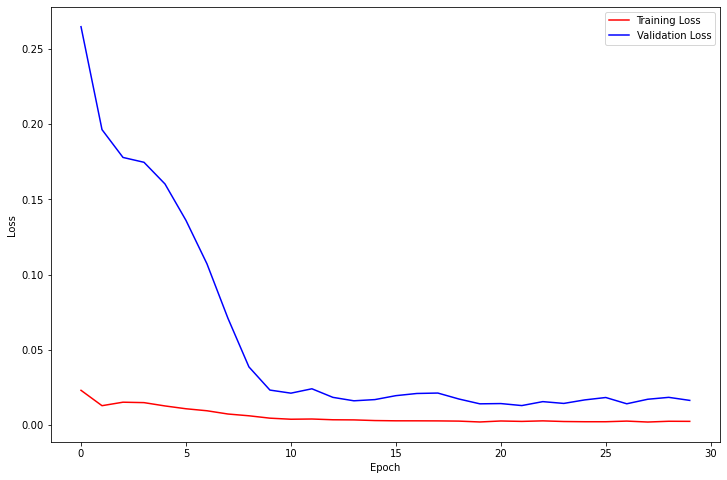

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [47]:
pred_test = model2.predict(X_test)
pred_train = model2.predict (X_train)

In [48]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data2['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()
results.head()

,y_test,Predictions,Date
0,0.466086,0.481568,2022-01-27
1,0.434061,0.471681,2022-01-28
2,0.435740,0.481123,2022-01-29
3,0.396858,0.471986,2022-01-30
4,0.449053,0.448287,2022-01-31


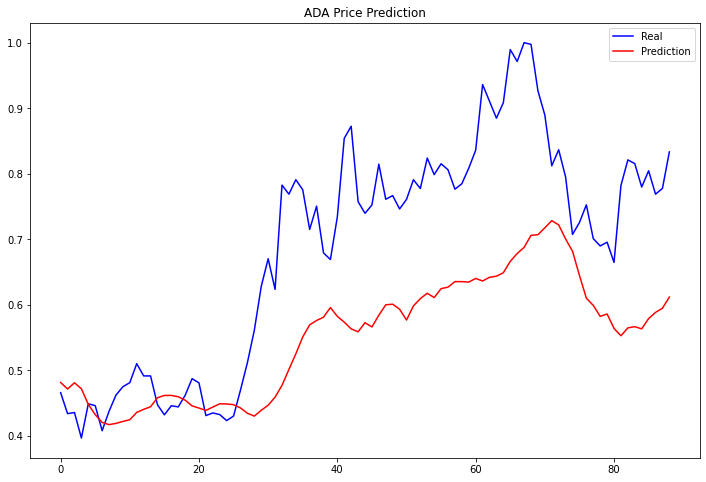

In [49]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('ADA Price Prediction')
plt.legend()
plt.show()

In [50]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.0653049882806125
Train data MSE:  0.004264741494330936
Train data MAE:  0.04254838154475691
-------------------------------------------------------------------------------------
Test data RMSE:  0.16891318921857415
Test data MSE:  0.02853166549198984
Test data MAE:  0.140677408133142


In [51]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.9064214352100591
Test data R2 score: 0.05062922183887919


# Model 2: XGBoost Regressor   <a name="xgboost2"></a>

In [52]:
data3 = luna.copy()

In [53]:
data3.reset_index(inplace = True)
data3 = data3[data3['Date'] >= '2021-01-01']               
data3.set_index('Date', inplace = True)
print("Total data for prediction: ",data3.shape[0])

Total data for prediction:  480


In [54]:
data3.shape

(480, 6)

In [55]:
training_size=int(len(data3)*0.80)
test_size=len(data3)-training_size
train_data,test_data=data3.iloc[:training_size,:],data3.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (384, 6)
test_data:  (96, 6)


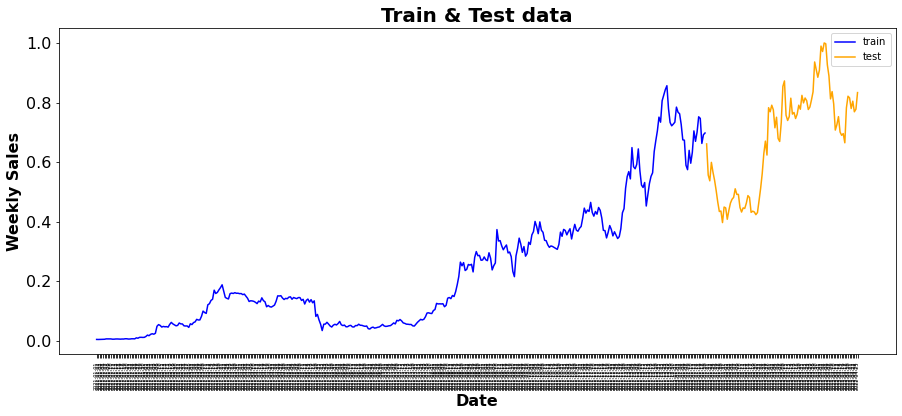

In [56]:
data3.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data3['Date'][:training_size], y = data3['close'][:training_size], color = 'blue')
sns.lineplot(x = data3['Date'][training_size:], y =data3['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [57]:
data3.set_index('Date', inplace = True)

In [58]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [59]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (376, 7, 6)
y_train:  (376,)
X_test:  (88, 7, 6)
y_test (88,)


In [60]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [61]:
model3 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model3.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [62]:
predictions = model3.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model3.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [63]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data3['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
83,0.815509,0.683087,2022-04-21
84,0.779765,0.721513,2022-04-22
85,0.804559,0.730357,2022-04-23
86,0.768891,0.744830,2022-04-24
87,0.777710,0.730239,2022-04-25


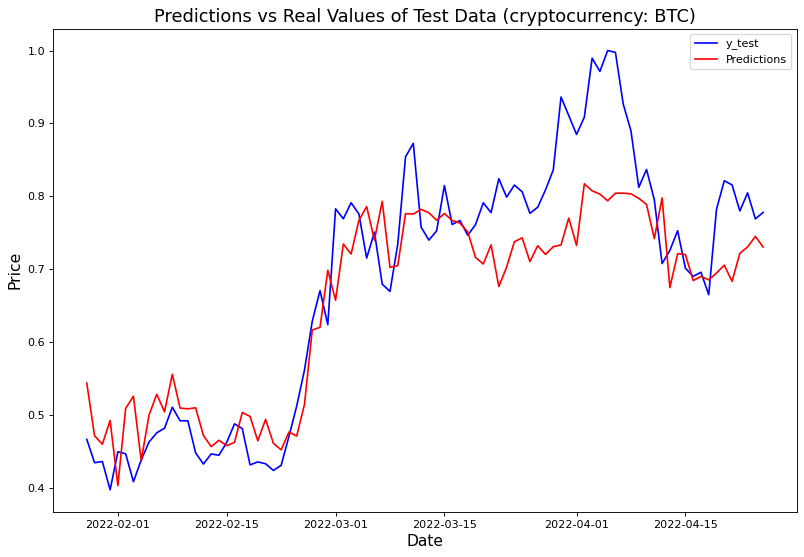

In [64]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: BTC)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [65]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  4.743315740221915e-07
Mean Absolute Error - MAE : 0.0004840735826561077
Root Mean squared Error - RMSE : 0.0006887173397136096
R^2 Score 0.9999891867561259
--------------------------------------------------------------
Test data MSE:  0.006121733205123276
Mean Absolute Error - MAE : 0.061151819074016144
Root Mean squared Error - RMSE : 0.07824150564197545
R^2 Score 0.7968830962287884


# LUNA - since January 2022  <a name="jan2022"></a>

# Model 1: LSTM <a name="lstm3"></a>

In [66]:
data4 = luna.copy()
data4.reset_index(inplace = True)
data4 = data4[data4['Date'] >= '2022-01-01']
data4.set_index('Date', inplace = True)
print("Total data for prediction: ",data4.shape[0])

Total data for prediction:  115


In [67]:
hist = []
target = []
length = 7

for i in range(len(data4)-length):
    t = data4['close']
    v = data4[['close','BTC_closeprice', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [68]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
108
108


In [69]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [70]:
target = target.reshape(-1,1)
target.shape

(108, 1)

In [71]:
training_size = int(len(data4)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [72]:
X_train.shape

(92, 7, 5)

In [73]:
model4 = tf.keras.Sequential()

model4.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,5), dropout = 0.2))

model4.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model4.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model4.add(layers.Dense(units=1))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 20)             2080      
                                                                 
 lstm_7 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
_________________________________________________________________


In [74]:
model4.compile(optimizer='adam', loss='mean_squared_error')

In [75]:
history = model4.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
3/3 [==============================] - 4s 279ms/step - loss: 0.3966 - val_loss: 0.7557
Epoch 2/30
3/3 [==============================] - 0s 22ms/step - loss: 0.3664 - val_loss: 0.7214
Epoch 3/30
3/3 [==============================] - 0s 23ms/step - loss: 0.3423 - val_loss: 0.6837
Epoch 4/30
3/3 [==============================] - 0s 25ms/step - loss: 0.3164 - val_loss: 0.6396
Epoch 5/30
3/3 [==============================] - 0s 27ms/step - loss: 0.2857 - val_loss: 0.5884
Epoch 6/30
3/3 [==============================] - 0s 24ms/step - loss: 0.2504 - val_loss: 0.5264
Epoch 7/30
3/3 [==============================] - 0s 23ms/step - loss: 0.2108 - val_loss: 0.4501
Epoch 8/30
3/3 [==============================] - 0s 29ms/step - loss: 0.1623 - val_loss: 0.3558
Epoch 9/30
3/3 [==============================] - 0s 20ms/step - loss: 0.1112 - val_loss: 0.2416
Epoch 10/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0626 - val_loss: 0.1177
Epoch 11/30
3/3 [===========

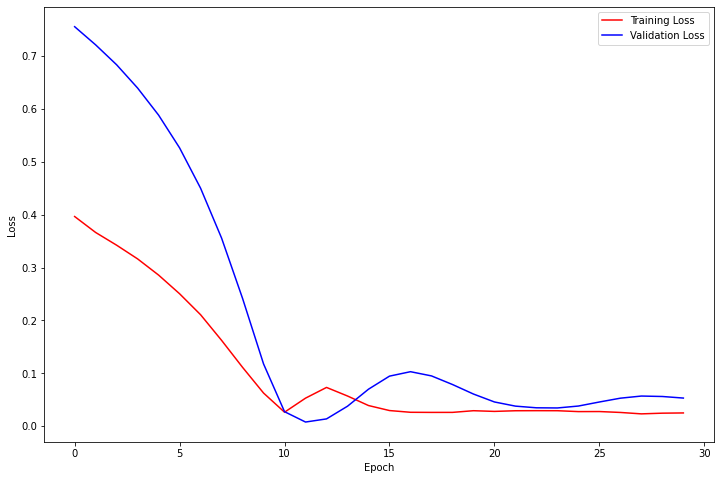

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [77]:
pred_test = model4.predict(X_test)
pred_train = model4.predict (X_train)

In [78]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data4['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
11,0.779765,0.609492,2022-04-21
12,0.804559,0.635807,2022-04-22
13,0.768891,0.635381,2022-04-23
14,0.777710,0.626202,2022-04-24
15,0.833397,0.639760,2022-04-25


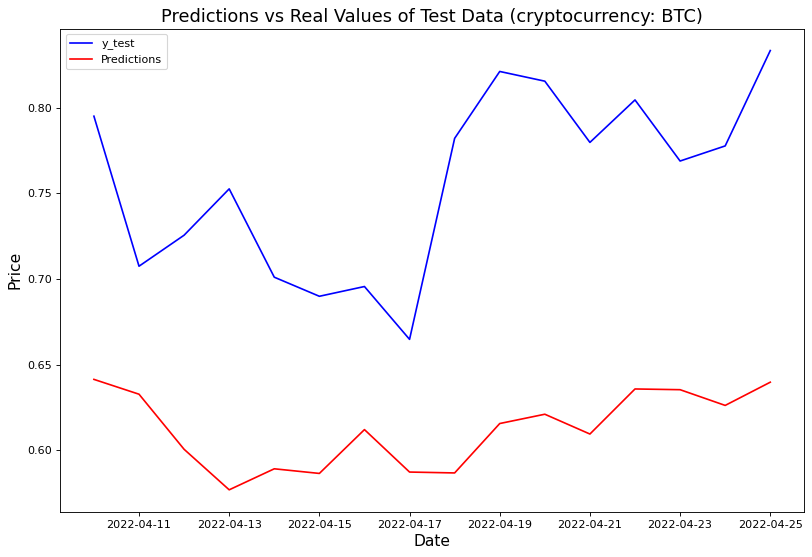

In [79]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results['Date'], results['y_test'], 'b', label = 'y_test')
plt.plot(results['Date'], results['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: BTC)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [80]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.1600479070433936
Train data MSE:  0.025615332548970762
Train data MAE:  0.14170506877939087
-------------------------------------------------------------------------------------
Test data RMSE:  0.15121678510987624
Test data MSE:  0.02286651609896649
Test data MAE:  0.14490391804692254


In [81]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.10909419152383326
Test data R2 score: -7.675784681262671


# Model 2: XGBoost Regressor   <a name="xgboost3"></a>

In [82]:
data5= luna.copy()
data5.reset_index(inplace = True)
data5 = data5[data5['Date'] >= '2022-01-01']
data5.set_index('Date', inplace = True)
print("Total data for prediction: ",data5.shape[0])

Total data for prediction:  115


In [83]:
training_size=int(len(data5)*0.80)
test_size=len(data5)-training_size
train_data,test_data=data5.iloc[:training_size,:],data5.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (92, 6)
test_data:  (23, 6)


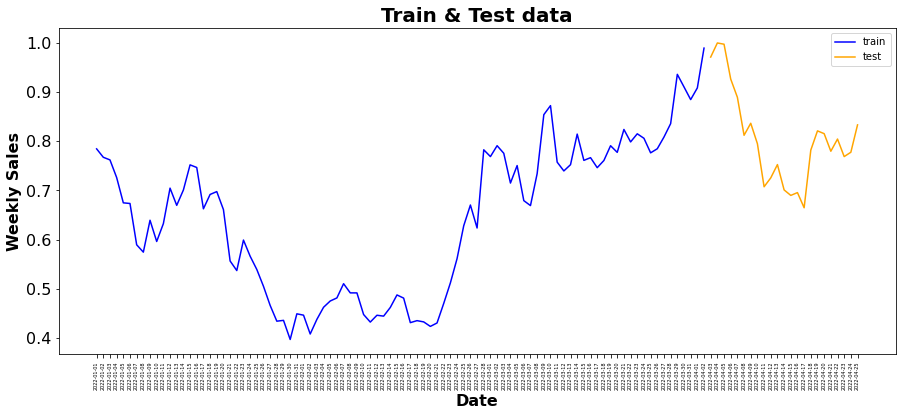

In [84]:
data5.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data5['Date'][:training_size], y = data5['close'][:training_size], color = 'blue')
sns.lineplot(x = data5['Date'][training_size:], y = data5['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [85]:
data5.set_index('Date', inplace = True)

In [86]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [87]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (84, 7, 6)
y_train:  (84,)
X_test:  (15, 7, 6)
y_test (15,)


In [88]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [89]:
model5 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model5.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [90]:
predictions = model5.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)


predictions_train = model5.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [91]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data5['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
10,0.815509,0.766834,2022-04-21
11,0.779765,0.761777,2022-04-22
12,0.804559,0.775301,2022-04-23
13,0.768891,0.767276,2022-04-24
14,0.777710,0.792751,2022-04-25


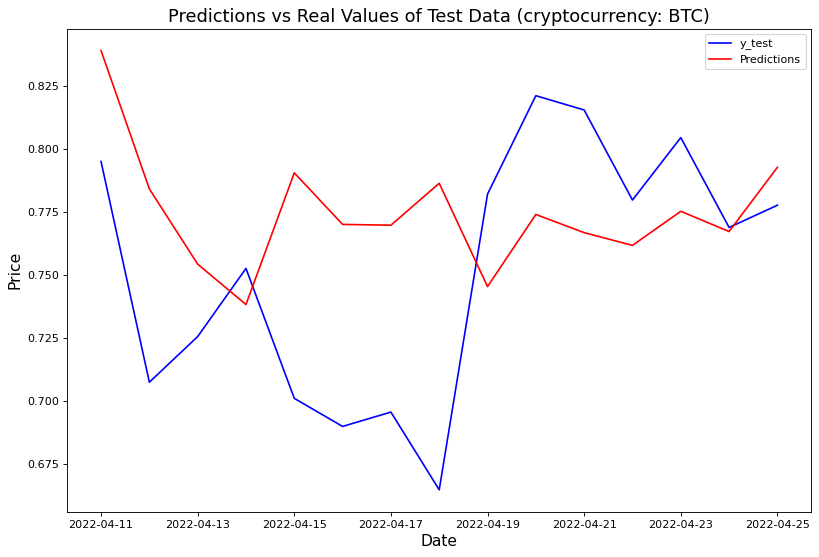

In [92]:
plt.figure(figsize = (12,8), dpi = 80 )
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: BTC)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [93]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  1.452600519662482e-07
Mean Absolute Error - MAE : 0.00027911513153595056
Root Mean squared Error - RMSE : 0.0003811299672897005
R^2 Score 0.9999938441098433
--------------------------------------------------------------
Test data MSE:  0.0033960528402422895
Mean Absolute Error - MAE : 0.04838317107173731
Root Mean squared Error - RMSE : 0.05827566250367549
R^2 Score -0.41586805014317485


# Predictions for the next two days using the best model <a name="predictions"></a>

In [94]:
#Importing the dataset with the updated data
#Use just the 7 past rows, because our model is predicting based on this sliding window
predictions = pd.read_csv('test_LUNA1.csv', index_col = 'Date')

In [95]:
predictions.tail(7)

,close,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,
2022-05-02,0.723953,0.228145,0.045447,0.949050,0.017292,0.536113
2022-05-03,0.709204,0.278990,0.041416,0.816444,0.002644,0.523670
2022-05-04,0.739975,0.327642,0.062318,0.886447,0.013245,0.554789
2022-05-05,0.709086,0.309425,0.092159,0.669211,0.064389,0.504894
2022-05-06,0.665094,0.231429,0.060055,0.651751,0.019347,0.496359
2022-05-07,0.585842,0.135647,0.172272,0.411563,0.019347,0.487749
2022-05-08,0.550820,0.083277,0.122156,0.739360,0.019347,0.467378


In [96]:
predictions1 = predictions.tail(7)
predictions1 = np.array(predictions1)

In [97]:
x_input=predictions1[len(predictions1)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output9=[]
n_steps=7
i=0
pred_days = 1


In [98]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output9.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output9))

0 day input [0.72395283 0.22814508 0.04544733 0.94904962 0.01729174 0.53611283
 0.70920424 0.27898978 0.04141599 0.81644432 0.00264389 0.52366995
 0.73997485 0.32764235 0.06231826 0.88644695 0.01324543 0.55478882
 0.70908608 0.30942524 0.09215947 0.6692115  0.06438862 0.5048938
 0.66509362 0.23142869 0.06005451 0.65175054 0.01934702 0.49635941
 0.58584182 0.13564744 0.17227211 0.41156304 0.01934702 0.48774915
 0.55082019 0.08327718 0.12215622 0.7393598  0.01934702 0.46737795]
0 day output [0.5976541]
Output of predicted next days:  1


In [99]:
output9  #predicted closing price for May 9th, 2022 (Monday)

[0.5976541042327881]

In [100]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[1 2 3 4 5 6 7]
[8]


In [101]:
# Inserting the prediction for the row May 9th, 2022 --> using new predicted value + data from May 8th 2022 for the other variables 

In [102]:
a = predictions.tail(1).copy()
a.reset_index(inplace = True)
a

,Date,close,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
0,2022-05-08,0.55082,0.083277,0.122156,0.73936,0.019347,0.467378


In [103]:
a.at[0,'Date']='2022-05-09'
a.at[0,'close']= output9[0]
a.set_index('Date', inplace = True)
a

,close,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,
2022-05-09,0.597654,0.083277,0.122156,0.73936,0.019347,0.467378


In [104]:
final_predictions = pd.concat([predictions, a], axis=0, join='outer')

In [105]:
#Get the predicted denormalized closing price using MinMaxScaler formula
intermediate_result = ((116.40892-0.125335)*output9[0])+0.125335

print ("The predicted closing price for LUNA1 on May 9th, 2022 is ", intermediate_result, "USD")

The predicted closing price for LUNA1 on May 9th, 2022 is  69.62269683015228 USD


# Final Predictions<a name="finalpredictions"></a>

In [106]:
final_predictions.tail(7)

,close,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,
2022-05-03,0.709204,0.278990,0.041416,0.816444,0.002644,0.523670
2022-05-04,0.739975,0.327642,0.062318,0.886447,0.013245,0.554789
2022-05-05,0.709086,0.309425,0.092159,0.669211,0.064389,0.504894
2022-05-06,0.665094,0.231429,0.060055,0.651751,0.019347,0.496359
2022-05-07,0.585842,0.135647,0.172272,0.411563,0.019347,0.487749
2022-05-08,0.550820,0.083277,0.122156,0.739360,0.019347,0.467378
2022-05-09,0.597654,0.083277,0.122156,0.739360,0.019347,0.467378


In [107]:
final_predictions1 = final_predictions.tail(7)
final_predictions1 = np.array(final_predictions1)

In [108]:
x_input=(final_predictions1[len(final_predictions1)-(time_step*time_step):]).reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output10=[]
n_steps=7
i=0
pred_days = 1

In [109]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output10.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output10))

0 day input [0.70920424 0.27898978 0.04141599 0.81644432 0.00264389 0.52366995
 0.73997485 0.32764235 0.06231826 0.88644695 0.01324543 0.55478882
 0.70908608 0.30942524 0.09215947 0.6692115  0.06438862 0.5048938
 0.66509362 0.23142869 0.06005451 0.65175054 0.01934702 0.49635941
 0.58584182 0.13564744 0.17227211 0.41156304 0.01934702 0.48774915
 0.55082019 0.08327718 0.12215622 0.7393598  0.01934702 0.46737795
 0.5976541  0.08327718 0.12215622 0.7393598  0.01934702 0.46737795]
0 day output [0.67006284]
Output of predicted next days:  1


In [110]:
print ("The predicted normalized closing price for LUNA1 on May 10th, 2022 is ", output10[0])

The predicted normalized closing price for LUNA1 on May 10th, 2022 is  0.6700628399848938


In [111]:
#Get the predicted denormalized closing price using MinMaxScaler formula
final_result = ((116.40892-0.125335)*output10[0])+0.125335

print ("The predicted closing price for LUNA1 on May 10th, 2022 is ", final_result, "USD")

The predicted closing price for LUNA1 on May 10th, 2022 is  78.0426442087248 USD
